# __TelecomX - Parte 2: Modelo de prediccion de cancelaciones__

# Objetivos

- Preparar los datos para el modelado (tratamiento, codificación, normalización).

- Realizar análisis de correlación y selección de variables.

- Entrenar dos o más modelos de clasificación.

- Evaluar el rendimiento de los modelos con métricas.

- Interpretar los resultados, incluyendo la importancia de las variables.

- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

# Entregables

- Analisis completo de los datos.

- Exportar modelo final.

- Informe con los hallazgos y recomendaciones.

# Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import pickle
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                             recall_score,accuracy_score, precision_score, make_scorer,f1_score)

from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold, KFold,
                                     cross_validate, RandomizedSearchCV, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as imbpipeline

from scipy import stats
from scipy.stats import t

# Preparacion de los datos

## Carga y exploracion

In [2]:
# libreria


In [3]:
# cargar datos previamente tratados desde github
data = pd.read_csv('https://raw.githubusercontent.com/jbernalg/challenge_TelecomX/refs/heads/main/data_out/datos_tratados.csv', sep=',')
data.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,...,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,...,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30,0.242963
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,...,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40,0.221852
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,...,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85,0.615833
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,...,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,...,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40,0.932222


In [4]:
# informacion de cada variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  streaming_TV             7032 non-null   object 
 14  streaming_peliculas     

In [5]:
# distribucion de cancelacion
data['cancelacion'].value_counts(normalize=True)*100

cancelacion
0    73.421502
1    26.578498
Name: proportion, dtype: float64

La proporcion de la variable objetivo es la siguiente:

> 73.42% de los clientes se mantienen en la empresa

> 26.57% de los clientes abandonan la empresa

> Se evidencia un desequilibrio entre los clientes que permanecen y abandonan la empresa. Debe ser tratado.

## Encoding

Para la codificacion binaria reemplazamos los 'Si' por 1 y los 'No' por 0. Para el resto de las variables, utilizamos OneHotEncoder

In [6]:
# Funcion para mapear variables binarias
def map_to_binary(df):

    df_copy = df.copy()

    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            unique_vals = df_copy[col].dropna().unique()
            if 'Si' in unique_vals:
                # Mapea 'Yes' a 1, todo lo demás a 0
                df_copy[col] = df_copy[col].apply(lambda x: 1 if x == 'Si' else 0)

    return df_copy

In [7]:
# codificamos variables binarias
df = map_to_binary(data)
df.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,...,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,0,1,1,9,1,0,DSL,0,...,0,1,1,0,un year,1,cheque por correo,65.6,593.30,0.242963
1,0,Masculino,0,0,0,9,1,1,DSL,0,...,0,0,0,1,mes a mes,0,cheque por correo,59.9,542.40,0.221852
2,1,Masculino,0,0,0,4,1,0,Fibra_optica,0,...,1,0,0,0,mes a mes,1,cheque electronico,73.9,280.85,0.615833
3,1,Masculino,1,1,0,13,1,0,Fibra_optica,0,...,1,0,1,1,mes a mes,1,cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,1,1,0,3,1,0,Fibra_optica,0,...,0,1,1,0,mes a mes,1,cheque por correo,83.9,267.40,0.932222


In [8]:
# separamos caracteristicas de la variable objetivo
X = df.drop(columns=['cancelacion'])
y = df['cancelacion']

In [9]:
# identificamos variables categoricas restantes a codificar
categorical_var = ['genero', 'servicio_internet', 'tipo_contrato', 'metodo_pago']

# configuramos el decodificador
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_var)],
                                 remainder='passthrough')

# aplicamos el encoded a las caracteristicas
X_encoded = preprocessor.fit_transform(X)

# agregamos los nombres de las nuevas variables codificadas
feature_names = preprocessor.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded_df.head()

,cat__genero_Masculino,cat__servicio_internet_Fibra_optica,cat__servicio_internet_No,cat__tipo_contrato_mes a mes,cat__tipo_contrato_un year,cat__metodo_pago_cheque por correo,cat__metodo_pago_tarjeta de credito,cat__metodo_pago_transferencia,remainder__jubilado,remainder__en_pareja,...,remainder__seguridad_online,remainder__respaldo_online,remainder__proteccion_dispositivo,remainder__soporte_efectivo,remainder__streaming_TV,remainder__streaming_peliculas,remainder__facturacion_electronica,remainder__cuenta_mensual,remainder__cuentas_total,remainder__cuentas_diarias
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,65.6,593.30,0.242963
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.9,542.40,0.221852
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,73.9,280.85,0.615833
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,98.0,1237.85,0.251282
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,83.9,267.40,0.932222


In [10]:
# agregamos variable obejtivo al df anterior para tener el df completo
df_codificado = pd.concat([X_encoded_df, y], axis=1)
df_codificado.head()

,cat__genero_Masculino,cat__servicio_internet_Fibra_optica,cat__servicio_internet_No,cat__tipo_contrato_mes a mes,cat__tipo_contrato_un year,cat__metodo_pago_cheque por correo,cat__metodo_pago_tarjeta de credito,cat__metodo_pago_transferencia,remainder__jubilado,remainder__en_pareja,...,remainder__respaldo_online,remainder__proteccion_dispositivo,remainder__soporte_efectivo,remainder__streaming_TV,remainder__streaming_peliculas,remainder__facturacion_electronica,remainder__cuenta_mensual,remainder__cuentas_total,remainder__cuentas_diarias,cancelacion
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,65.6,593.30,0.242963,0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,59.9,542.40,0.221852,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,73.9,280.85,0.615833,1
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,98.0,1237.85,0.251282,1
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,83.9,267.40,0.932222,1


## Eliminar caracteristicas irrelevantes

En el analisis realizado en el proyecto anterior, notamos que __cuenta_mensual__ esta altamente relacionada con __cuentas_total__. Esto se debe a la naturaleza acumulativa de __cuenta_mensual__, por lo que la eliminamos para asi simplificar un poco el dataset.

In [11]:
# eliminar remainder__cuenta_mensual
df_codificado.drop('remainder__cuenta_mensual', axis=1, inplace=True)
df_codificado.head()

,cat__genero_Masculino,cat__servicio_internet_Fibra_optica,cat__servicio_internet_No,cat__tipo_contrato_mes a mes,cat__tipo_contrato_un year,cat__metodo_pago_cheque por correo,cat__metodo_pago_tarjeta de credito,cat__metodo_pago_transferencia,remainder__jubilado,remainder__en_pareja,...,remainder__seguridad_online,remainder__respaldo_online,remainder__proteccion_dispositivo,remainder__soporte_efectivo,remainder__streaming_TV,remainder__streaming_peliculas,remainder__facturacion_electronica,remainder__cuentas_total,remainder__cuentas_diarias,cancelacion
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,593.30,0.242963,0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,542.40,0.221852,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,280.85,0.615833,1
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1237.85,0.251282,1
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,267.40,0.932222,1


# Analsis de correlacion

Vamos a analizar la correlacion entre la variable objetivos y las caracteristicas. Para simplificar la visualizacion y concentrarnos en las correlaciones importantes, asignamos un umbral del 15% con la variable '__cancelacion__'. Esto solo tomara en cuenta las correlaciones mayores a 0.15 con la variable objetivo.

In [12]:
# matriz de correlacion
corr_matrix = df_codificado.corr()

# obtener correlaciones con 'cancelacion'
corr_cancelacion = corr_matrix['cancelacion'].drop('cancelacion')

# filtramos por umbral
corr_filter = corr_cancelacion[abs(corr_cancelacion) > 0.15].sort_values(ascending=False)

# tabla de correlaciones ordenadas
corr_filter

cat__tipo_contrato_mes a mes           0.404565
remainder__cuentas_diarias             0.386065
cat__servicio_internet_Fibra_optica    0.307463
remainder__facturacion_electronica     0.191454
remainder__jubilado                    0.150541
remainder__dependientes               -0.163128
remainder__soporte_efectivo           -0.164716
remainder__seguridad_online           -0.171270
cat__tipo_contrato_un year            -0.178225
remainder__cuentas_total              -0.199484
cat__servicio_internet_No             -0.227578
remainder__meses_contrato             -0.354049
Name: cancelacion, dtype: float64

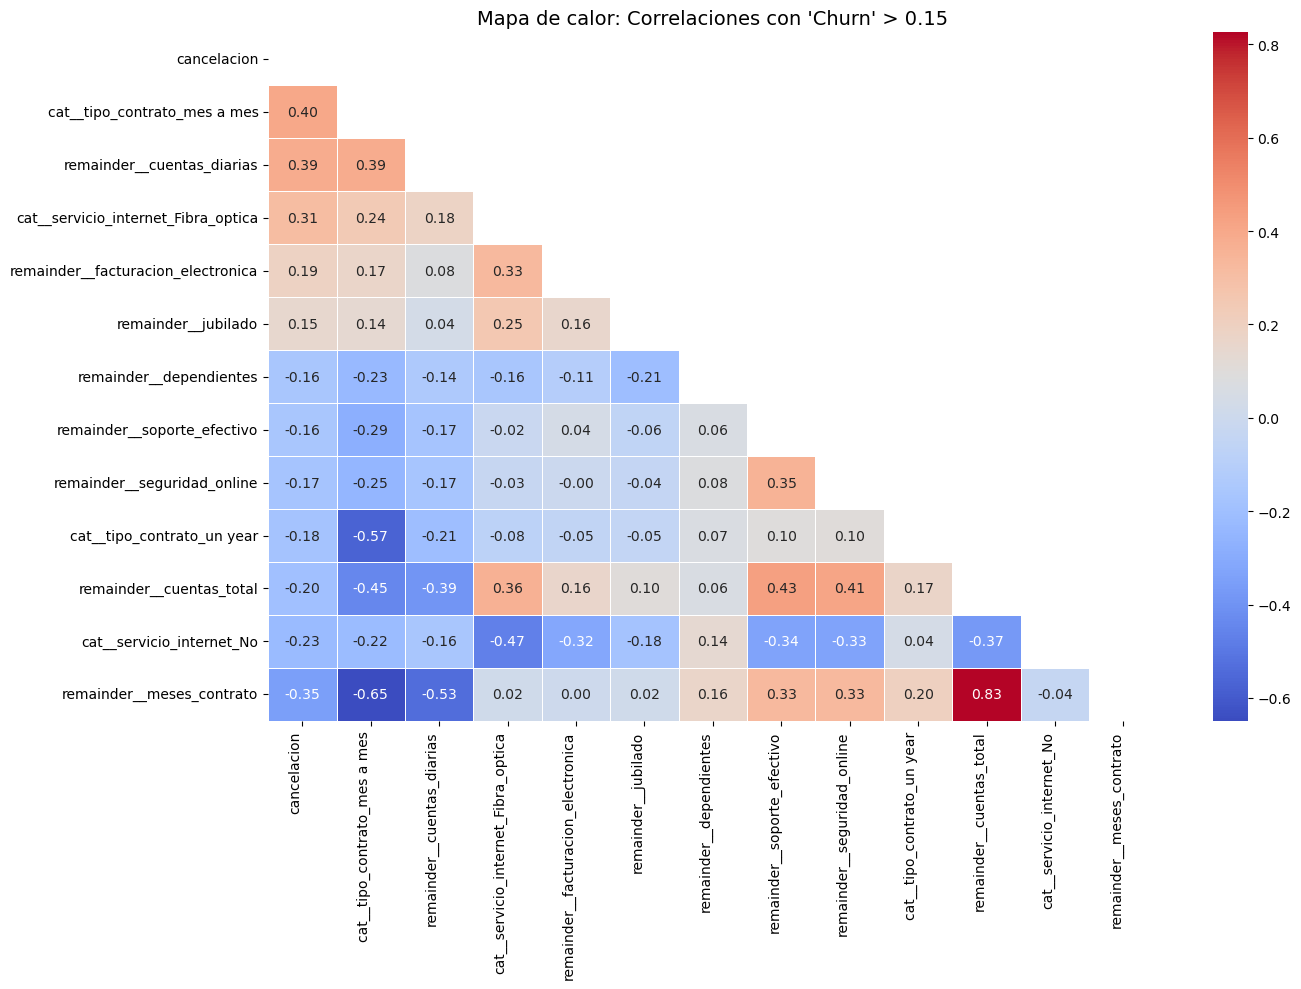

In [14]:
# Creamos submatriz para heatmap
variables = ['cancelacion'] + list(corr_filter.index)
matrix_corr_filter = corr_matrix.loc[variables, variables]

# Creamos máscara inferior
mask = np.triu(np.ones_like(matrix_corr_filter, dtype=bool))

# Plot del heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(matrix_corr_filter, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Mapa de calor: Correlaciones con 'Churn' > 0.15",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.grid(False)

> Los modelos con los que vamos a trabajar son: DecisionTreeClassiffier, RandomForestClassiffier y CatBoost. Tales modelos no son sensibles a la multicolinealidad por lo que en este caso, en analisis de correlacion no aporta valor a los modelos.

# Probando Modelos

Nuestro obejtivo es encontrar un modelo donde el recall para '__cancelan__' sea el mayor posible. Esto quiere decir, que buscamos identificar lo mejor posible aquellos clientes que cancelan el servicio con la empresa.

Para ello, utilizamos tres modelo:

- DecisionTreeClassiffier
- RandomForestClassiffier
- CatBoost

## Modelo #1: DesicionTree sin optimizaciones

In [15]:
# separamos caracteristicas de la variable objetivo
X = df_codificado.drop('cancelacion', axis=1)
y = df['cancelacion']

# dividimos datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos el modelo
model = DecisionTreeClassifier(random_state=42, max_depth=10)

# entrenamos el modelo
model.fit(X_train, y_train)

# generamos las predicciones del modelo
y_pred = model.predict(X_test)

# evaluamos el modelo
print('-----------Reporte del modelo DesicionTree sin optimizar-----------')
print(classification_report(y_test, y_pred))

-----------Reporte del modelo DesicionTree sin optimizar-----------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.52      0.56       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [17]:
# funcion para mostrar la matriz de confusion a partir de los datos de prueba y las predicciones

def plot_confusion_matrix(y_test, y_previsto, modelo:str):
  # creamos la matriz de confusión
  cm = confusion_matrix(y_test, y_previsto)

  # creamos el gráfico de la matriz de confusión
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Permanece', 'Cancela'])
  disp.plot(cmap='Blues')
  plt.title(f'Matriz de Confusión {modelo}', color='firebrick', fontsize=12)
  plt.show()

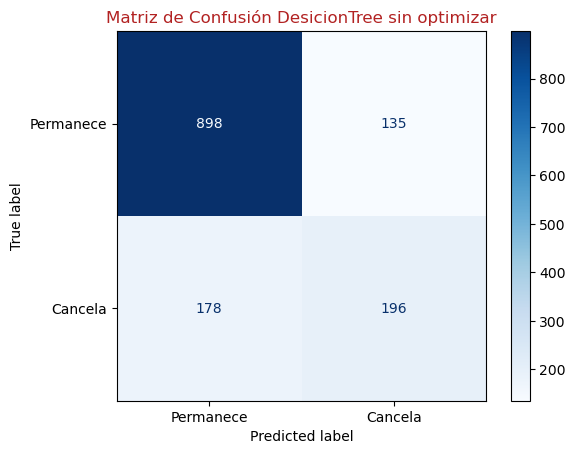

In [ ]:
# generamos la matriz de confusion
plot_confusion_matrix(y_test, y_pred, 'DesicionTree sin optimizar')

__Interpretacion de los resultados__

> El modelo predice correctamente 898 clientes que permanecen con la empresa (Verdaderos Negativos TN). Esto representa un 63.8% de aciertos. 85% de Recall.

> El modelo predice erroneamente 135 clientes que permanecen como clientes que cancelan (Falsos Positivos FP). Esto representa 9.5% de desaciertos.

> El modelo predice erroneamente 178 clientes que cancelan como clientes que permanecen (Falsos Negativos FN). Esto representa 12.6% de desaciertos.

> El modelo predice correctamente 196 clientes que cancelan con la empresa (Verdaderos Positivos TP). Representa 13.9% de aciertos. 56% de Recall.

Este modelo es inutil para predecir correctamente los clientes que cancelan ya que solo identifica correctamente al 56% de ellos a pesar que identifica correctamente al 85% de los que permanecen con la empresa.